In [2]:
# %pip install openpyxl
# %pip install seaborn
# %pip install pygris

# X Industry is Y more likely to have employees in violation
#      Share of Employees Employed in Violation by Indsutry

# X Industry has $Y in Back Wages per Employee Receiving Back Wages
#      When back wages are owed by industry, each employee gets how much $

# X Industry has Y employees owed back wages out of Z total payroll employees
#      How common is the back wages by industry?

# https://labor.fiu.edu/publications/faculty-publications/wage-theft-report-for-hillsborough-county.pdf
#      68% of 4,387 low-wage workers in CHI, LAX, NYC had at least 1 wage theft experience
#      Given 1 wage theft experience, workers lost 15% of $17,616 annual earnings
#      Place of Victim Residence --- ACS Employed Household Income by NAICS
#      Place of Victim Employment --- Zip Business Patterns by NAICS


#      wage theft by tract (res) = # employed * (15% * $ earned expected) by NAICS ... assume employee counts and earnings
#      wage theft by tract (emp) = annual payroll * 115% by NAICS ... assume payrolls are short 15%

# https://api.census.gov/data/2018/zbp/variables.html
#      https://api.census.gov/data/2018/zbp?get=NAME,GEO_ID,NAICS2017_LABEL,PAYANN,ESTAB,EMP&for=zip%20code:90210&NAICS2017=23
#      ZCTA by NAICS number of employees (EMP), number of business (ESTAB), annual payroll (PAYANN)
#      https://www.census.gov/programs-surveys/economic-census/year/2022/guidance/understanding-naics.html
#      https://data.census.gov/map/040XX00US12$8600000/ACSST5Y2022/S0101?q=naics&layer=VT_2022_860_Z2_PY_D1&loc=28.2392,-82.4491,z9.6493

# https://files.epi.org/pdf/125116.pdf

In [3]:
import pandas as pd
import openpyxl
import seaborn as sns
from pygris import zctas,counties,tracts
import matplotlib.pyplot as plt
path1    = "https://www.dol.gov/sites/dolgov/files/WHD/data/2023/sheets/h2b.xlsx"
path2    = "https://www.dol.gov/sites/dolgov/files/WHD/data/2023/sheets/low-wage-high-violation.xlsx"
path3    = "/BLS_Table2.11_Transformed.csv" # BLS blocked auto-download https://www.bls.gov/emp/tables/employment-by-major-industry-sector.htm
path_out = "/backwagesbyindustry_dol_2013_2023.csv"
path_out2= "/backwagesbytract_2022.csv"
api_key  = '' # get US Census API Key

In [4]:
# flag tracts for likely victim of wagetheft residence risk ...

# https://www.census.gov/programs-surveys/community-resilience-estimates/technical-documentation/methodology.html
# The number of people with:
    # 0 risk factors (Low risk)
    # 1-2 risk factors (Medium risk)
    # 3 or more risk factors (High risk) ***Mapping Rate of population with 3 or more from Census CRE Program
# All Risk Factors List
    # Income-to-Poverty Ratio (IPR) < 130 percent (Household)
    # Single or zero caregiver household - only one or no individuals living in the household who are 18-64 (Household)
    # Unit-level crowding with >= 0.75 persons per room (Household)
    # Communication Barrier defined as:
    # No one in the household has received a high school diploma
    # No one in the household speaks English “very well”
    # Aged 65 years or older
    # No one in the household is employed full-time, year-round. The flag is not applied if all residents of the household are aged 65 years or older (Household)
    # Disability, at least one serious constraint to significant life activity
    # No health insurance coverage
    # No vehicle access (Household)
    # Households without broadband internet access (Household)


# then calc annual wage theft by tract for top 5 high risk NAICS ...
#      S0501_C01_066E ... total employees * 
#      FIU or DoL     ... pct experiencing wage theft(68%)<low,med,high> *  ----- prevalence could be improved; DOL vs survey an underreporting estimate?
#      BLS cpsaat39   ... (median weekly earnings * 52 weeks * 0.15<low,med,high>)  ----- when back wages are owed, surveys show 15% of total wages lost


Using FIPS code '12' for input 'FL'
Using FIPS code '101' for input 'Pasco'
Using FIPS code '12' for input 'FL'
Using FIPS code '101' for input 'Pasco'
825201.0 Estimated Back Wages Owed for All Industries


Text(0.5, 1.0, 'Pasco wages_owed_dollars_allind by Tracts, 2022')

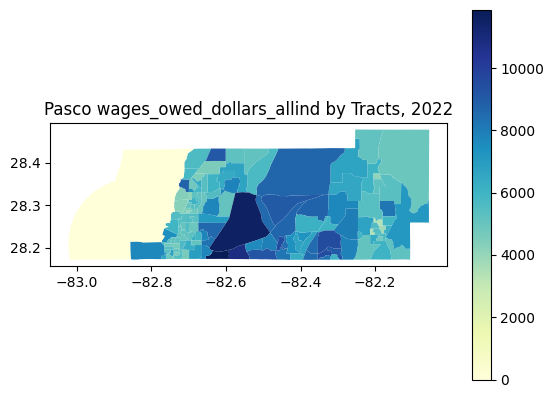

In [5]:
# Mapping US Census 2022 CRE program estimates based on ACS 5yr data by tract
# Which tracts have high rates of vulnearable people? Can do tracts with largest numbers of vulnearable people...

# Pull geography information for mapping
county_var  = 'Pasco'
state_var   = 'FL'
year_var    = 2022
year_str    = '2022'
api_table   = 'cre'
var_strlist = 'NAME,PRED3_PE' #find variables!!!
var_names   = {'PRED3_PE':'rate_3plus_vul_ind'}
census_ints = ['rate_3plus_vul_ind']

gpd_tracts_pasco = tracts(county=county_var,state=state_var,year=year_var,cache=False)
# grab state FIPS from gpd_tracts_pasco 
state_fips  = ','.join(str(x) for x in gpd_tracts_pasco.STATEFP.unique())
county_fips = ','.join(str(x) for x in gpd_tracts_pasco.COUNTYFP.unique())
# naics_strlist = '00'#,72,62,23,71,44,45' #pull NAICS data by variable name within var_strlist

# Pulling data from api.census.gov

url = f"https://api.census.gov/data/{year_str}/{api_table}?get={var_strlist}&for=tract:*&in=state:{state_fips}&in=county:{county_fips}&key={api_key}"

df_tracts_cre   = pd.read_json(url)
df_tracts_cre   = df_tracts_cre.rename(columns=df_tracts_cre.iloc[0]).drop(df_tracts_cre.index[0])
df_tracts_cre   = df_tracts_cre.rename(columns=var_names)
df_tracts_cre[census_ints] = df_tracts_cre[census_ints].fillna(0).astype(float)

df_tracts_cre = pd.concat([pd.DataFrame(),df_tracts_cre])

# # Plotting the map

# col = 'rate_3plus_vul_ind' # different variable for acs5

# plotdf = gpd_tracts_pasco.merge(df_tracts_acs5.loc[:,[col,'tract']],left_on='TRACTCE',right_on='tract')

# fig, ax = plt.subplots()
# plotdf[[col,'geometry']].plot(column=col,ax = ax, cmap='YlGnBu',legend=True)
# # gpd_county_pasco.plot(ax = ax,edgecolor='black', facecolor='none', linewidth=5)
# plt.title(f'{county_var} {col} by Tracts, {year_str}')


# Mapping US Census 2022 ACS 5yr data by tract showing number of employees and median earnings by top 5 NAICS for backwages (per DoL)

# industry   2022 NAICS
# construction  23
# retail    44-45
# health care   62
# hotels and motels 71
# food services 72

# Pull geography information for mapping
county_var  = 'Pasco'
state_var   = 'FL'
year_var    = 2022
year_str    = '2022'
api_table   = 'acs/acs5/subject'
var_strlist = 'NAME,S2413_C01_001E,S2413_C01_005E,S2413_C01_008E,S2413_C01_022E,S2413_C01_025E,S2404_C01_001E,S2404_C01_005E,S2404_C01_008E,S2404_C01_022E,S2404_C01_025E' #add total employees & earnings for top 5 NAICS
var_names   = {'S2413_C01_001E':'med_earnings_dollars_allind',
               'S2413_C01_005E':'med_earnings_dollars_construct',
               'S2413_C01_008E':'med_earnings_dollars_retail',
               'S2413_C01_022E':'med_earnings_dollars_health',
               'S2413_C01_025E':'med_earnings_dollars_hotelfood',
               'S2404_C01_001E':'count_emp_allind',
               'S2404_C01_005E':'count_emp_construct',  #S2404
               'S2404_C01_008E':'count_emp_retail',
               'S2404_C01_022E':'count_emp_health',
               'S2404_C01_025E':'count_emp_hotelfood'}
census_ints = ['med_earnings_dollars_allind',
               'med_earnings_dollars_construct',
               'med_earnings_dollars_retail',
               'med_earnings_dollars_health',
               'med_earnings_dollars_hotelfood',
               'count_emp_allind',
               'count_emp_construct',
               'count_emp_retail',
               'count_emp_health',
               'count_emp_hotelfood']
col         = 'wages_owed_dollars_allind'

gpd_tracts_pasco = tracts(county=county_var,state=state_var,year=year_var,cache=False)
# grab state FIPS from gpd_tracts_pasco 
state_fips  = ','.join(str(x) for x in gpd_tracts_pasco.STATEFP.unique())
county_fips = ','.join(str(x) for x in gpd_tracts_pasco.COUNTYFP.unique())
# naics_strlist = '00'#,72,62,23,71,44,45' #pull NAICS data by variable name within var_strlist

# Pulling data from api.census.gov

url = f"https://api.census.gov/data/{year_str}/{api_table}?get={var_strlist}&for=tract:*&in=state:{state_fips}&in=county:{county_fips}&key={api_key}"

df_tracts_acs5   = pd.read_json(url)
df_tracts_acs5   = df_tracts_acs5.rename(columns=df_tracts_acs5.iloc[0]).drop(df_tracts_acs5.index[0])
df_tracts_acs5   = df_tracts_acs5.rename(columns=var_names)
df_tracts_acs5[census_ints] = df_tracts_acs5[census_ints].fillna(0).astype(int)

df_tracts_acs5.loc[df_tracts_acs5.med_earnings_dollars_allind<0,'med_earnings_dollars_allind'] = 0
df_tracts_acs5.loc[df_tracts_acs5.med_earnings_dollars_construct<0,'med_earnings_dollars_construct'] = 0
df_tracts_acs5.loc[df_tracts_acs5.med_earnings_dollars_retail<0,'med_earnings_dollars_retail'] = 0
df_tracts_acs5.loc[df_tracts_acs5.med_earnings_dollars_health<0,'med_earnings_dollars_health'] = 0
df_tracts_acs5.loc[df_tracts_acs5.med_earnings_dollars_hotelfood<0,'med_earnings_dollars_hotelfood'] = 0

df_tracts_acs5 = pd.concat([pd.DataFrame(),df_tracts_acs5])

# Plotting the map

df_tracts_merged = gpd_tracts_pasco.merge(df_tracts_acs5,left_on='TRACTCE',right_on='tract').merge(df_tracts_cre,left_on='TRACTCE',right_on='tract')
df_tracts_merged.drop(columns=['GEOID','NAME_x','NAMELSAD','MTFCC','FUNCSTAT',
                              'ALAND','AWATER', 'INTPTLAT', 'INTPTLON','NAME_y',
                               'state_x', 'county_x','tract_x','state_y', 'county_y','tract_y'
                              ],inplace=True)

# total employees * pct experiencing wage theft(0.68 or 0.002?)<low,med,high> * (median annual earnings * percent of wages owed 0.15<low,med,high>

df_tracts_merged['emp_wagetheft_yes_allind_0002'] = round(df_tracts_merged['count_emp_allind']*0.002,0)
df_tracts_merged['emp_wagetheft_yes_allind_068']  = round(df_tracts_merged['count_emp_allind']*0.68,0)

df_tracts_merged['wages_owed_dollars_allind']     = round(df_tracts_merged['med_earnings_dollars_allind']*0.15,0)

print(df_tracts_merged.wages_owed_dollars_allind.sum()
      ,'Estimated Back Wages Owed for All Industries') #merge with CRE above to filter only on Tracts where +30% of Households have 3+ Risk Factors

df_tracts_merged.to_csv(path_out2)

fig, ax = plt.subplots()
df_tracts_merged[[col,'geometry']].plot(column=col,ax = ax, cmap='YlGnBu',legend=True)
# gpd_county_pasco.plot(ax = ax,edgecolor='black', facecolor='none', linewidth=5)
plt.title(f'{county_var} {col} by Tracts, {year_str}')

# Interesting Findings

In [6]:
"""
Top 5 by employees receiving back wages is

'72,62,23,71,44,45'

industry	 2022 NAICS
construction	23
retail	44-45
health care	62
hotels and motels	71
food services	72

2022 NAICS
11	Agriculture, Forestry, Fishing and Hunting
21	Mining, Quarrying, and Oil and Gas Extraction
22	Utilities
23	Construction
31-33	Manufacturing
42	Wholesale Trade
44-45	Retail Trade
48-49	Transportation and Warehousing
51	Information
52	Finance and Insurance
53	Real Estate and Rental and Leasing
54	Professional, Scientific, and Technical Services
55	Management of Companies and Enterprises
56	Administrative and Support and Waste Management and Remediation Services
61	Educational Services
62	Health Care and Social Assistance
71	Arts, Entertainment, and Recreation
72	Accommodation and Food Services
81	Other Services (except Public Administration)
92	Public Administration (not covered in economic census)

2017 NAICS ***needed for 2018 ZIPs
11	Agriculture, Forestry, Fishing and Hunting
21	Mining, Quarrying, and Oil and Gas Extraction
22	Utilities
23	Construction
31-33	Manufacturing
42	Wholesale Trade
44-45	Retail Trade
48-49	Transportation and Warehousing
51	Information
52	Finance and Insurance
53	Real Estate and Rental and Leasing
54	Professional, Scientific, and Technical Services
55	Management of Companies and Enterprises
56	Administrative and Support and Waste Management and Remediation Services
61	Educational Services
62	Health Care and Social Assistance
71	Arts, Entertainment, and Recreation
72	Accommodation and Food Services
81	Other Services (except Public Administration)
92	Public Administration
"""

"\nTop 5 by employees receiving back wages is\n\n'72,62,23,71,44,45'\n\nindustry\t 2022 NAICS\nconstruction\t23\nretail\t44-45\nhealth care\t62\nhotels and motels\t71\nfood services\t72\n\n2022 NAICS\n11\tAgriculture, Forestry, Fishing and Hunting\n21\tMining, Quarrying, and Oil and Gas Extraction\n22\tUtilities\n23\tConstruction\n31-33\tManufacturing\n42\tWholesale Trade\n44-45\tRetail Trade\n48-49\tTransportation and Warehousing\n51\tInformation\n52\tFinance and Insurance\n53\tReal Estate and Rental and Leasing\n54\tProfessional, Scientific, and Technical Services\n55\tManagement of Companies and Enterprises\n56\tAdministrative and Support and Waste Management and Remediation Services\n61\tEducational Services\n62\tHealth Care and Social Assistance\n71\tArts, Entertainment, and Recreation\n72\tAccommodation and Food Services\n81\tOther Services (except Public Administration)\n92\tPublic Administration (not covered in economic census)\n\n2017 NAICS ***needed for 2018 ZIPs\n11\tAgricul

In [7]:
# Read in path1 file and transform
df1         = pd.read_excel(path1).loc[:8].T
df1_cols    = ['year','metric'] + df1.loc['Compliance Action Summary',2:].str.lower().to_list()
df1         = df1.reset_index(drop=True).loc[1:,:]
df1.columns = df1_cols
for i in [1,6,11,16,21,26,31,36,41,46,51]:
    df1.loc[i:i+4].loc[:,'year'] = pd.to_datetime(df1.loc[i].year[-4:])
df1.set_index('year',inplace=True)
df1 = pd.melt(df1,id_vars='metric', var_name='industry',value_name='value', ignore_index=False)

# Read in path2 file and transform
df2         = pd.read_excel(path2).T
df2_cols    = ['year','metric'] + df2.loc['Low Wage, High Violation Industries',2:].str.lower().to_list()
df2         = df2.reset_index(drop=True).loc[1:,:]
df2.columns = df2_cols
for i in [1,5,9,13,17,21,25,29,33,37,41]:
    df2.loc[i:i+3].loc[:,'year'] = pd.to_datetime(df2.loc[i].year[-4:])
df2.set_index('year',inplace=True)
df2 = pd.melt(df2,id_vars='metric', var_name='industry',value_name='value', ignore_index=False)
df2.loc[df2.metric=='Employees Receiving Back Wages Receiving Back Wages','metric'] = 'Employees Receiving Back Wages'

# Read in path3 file and transform
df3          = pd.read_csv(path3) # manually changed 2012 to be 2013, plus simplified industry name mapped to DOL from BLS
df3['year']  = pd.to_datetime(df3.year)
df3['value'] = df3['value']*1000
df3.set_index('year',inplace=True)

# Combine all files into one file
df = pd.concat([df1,df2,df3])

# Calculate Back Wages per employee (impact) & Percent of Employees Owed (prevalance)
for i in df.industry.unique():    
    for year in df.index.unique():
        val_backwages = df.loc[(df.industry==i) &
                             (df.index.isin([year])) &
                             (df.metric.isin(['Back Wages'])),'value'].iloc[0]
        val_backwages_employees = df.loc[(df.industry==i) &
                             (df.index.isin([year])) &
                             (df.metric.isin(['Employees Receiving Back Wages'])),'value'].iloc[0]
        calc_value1    = val_backwages / val_backwages_employees
        data1 = {'metric':'Back Wages per Employee', 'industry':i,'value':calc_value1}
        
        try:
            val_total_employees = df.loc[(df.industry==i) &
                             (df.index.isin([year])) &
                             (df.metric.isin(['Total Employment'])),'value'].iloc[0]
            calc_value2    = round(100*(val_backwages_employees / val_total_employees),2)     
            data2 = {'metric':'Percent of Total Employees Owed Back Wages', 'industry':i,'value':calc_value2}
            new_rows_df = pd.DataFrame([data1,data2])
            new_rows_df.index = [pd.to_datetime(year),pd.to_datetime(year)]
        except:
            new_rows_df = pd.DataFrame([data1])
            new_rows_df.index = [pd.to_datetime(year)]

        
        df = pd.concat([df,new_rows_df])

df.head(5)
df.to_csv(path_out)

In [8]:
#   Risk out of 10 = if(
#      VAR?           ... top 5 NAICS for employees receiving back wages employs +50%=2,
#      S0501_C01_107E ... poverty rate in tract +5%=2,
#      VAR?           ... % female employed in NAICS total +50%=2,
#      B23013_001E    ... median employed age in tract <30=2)

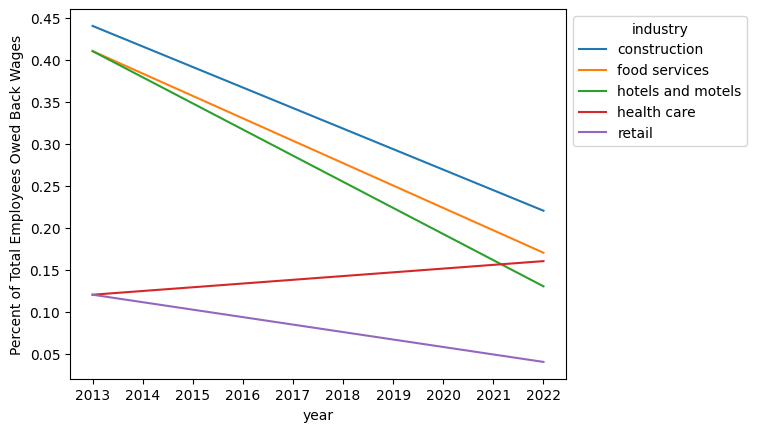

In [9]:
# After plotting Percent of Employees Owed Back Wages trends, prevalence is low < 0.5% per NAICS with only health care getting worse over time
# 2022 percent will be used for estimating prevalence

col = 'Percent of Total Employees Owed Back Wages'

df_to_plot = df.loc[df.metric==col][['industry','value']]
df_to_plot.columns = ['industry',col]

ax = sns.lineplot(data=df_to_plot, x=df_to_plot.index, y=col, hue='industry')
ax.set_xlabel('year')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

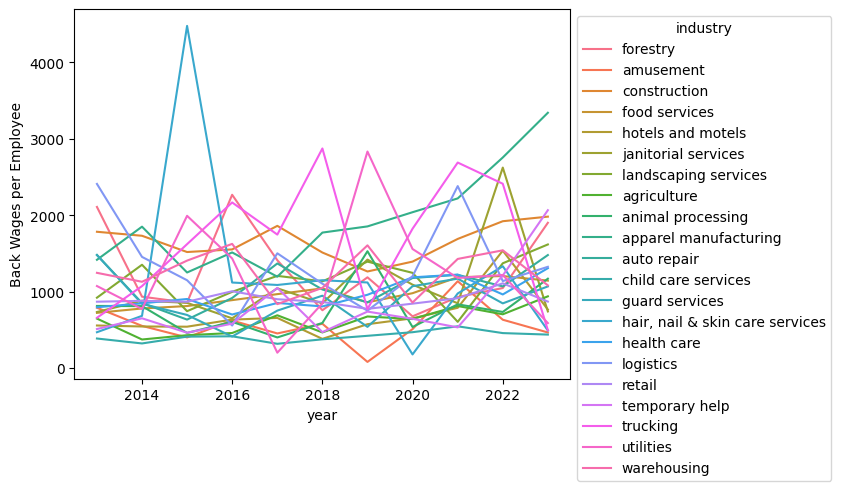

In [10]:
# After plotting Back Wages per Employee trends, we can use a 10yr mean per industry for wage theft estimates

df_to_plot = df.loc[df.metric=='Back Wages per Employee'][['industry','value']]
df_to_plot.columns = ['industry','Back Wages per Employee']

ax = sns.lineplot(data=df_to_plot, x=df_to_plot.index, y='Back Wages per Employee', hue='industry')
ax.set_xlabel('year')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [11]:
# Which industries are changing over time the most?

df_to_plot = df.loc[df.metric=='Back Wages per Employee'][['industry','value']]
df_to_plot.columns = ['industry','Back Wages per Employee']

df_bw_post2018 = df_to_plot.loc[df_to_plot.index>pd.to_datetime('2018')].groupby('industry').mean().sort_values(by=df_to_plot.columns[1],ascending=False)
df_bw_pre2018  = df_to_plot.loc[df_to_plot.index<pd.to_datetime('2018')].groupby('industry').mean().sort_values(by=df_to_plot.columns[1],ascending=False)

df_bw_means = pd.concat([df_bw_pre2018,df_bw_post2018],axis=1)
df_bw_means.columns = ["Pre-2018, Back Wages per Employee","Post-2018, Back Wages per Employee"]
df_bw_means['Diff'] = df_bw_means['Post-2018, Back Wages per Employee'] - df_bw_means['Pre-2018, Back Wages per Employee']
df_bw_means['Percent Diff'] = 100*(df_bw_means['Diff'] / df_bw_means['Pre-2018, Back Wages per Employee'])

df_bw_means.sort_values(by='Percent Diff',ascending=False)

,"Pre-2018, Back Wages per Employee","Post-2018, Back Wages per Employee",Diff,Percent Diff
industry,,,,
apparel manufacturing,1445.516452,2441.942623,996.426171,68.932192
janitorial services,833.067045,1344.83312,511.766075,61.431559
temporary help,651.295293,1038.889413,387.594119,59.511273
animal processing,618.370617,961.045518,342.674901,55.41578
hotels and motels,587.005881,863.526438,276.520558,47.106948
agriculture,520.586001,754.559134,233.973133,44.944185
health care,820.232532,1128.116888,307.884356,37.536228
utilities,1095.259866,1475.691639,380.431774,34.734385
food services,834.444622,1075.87247,241.427848,28.932759


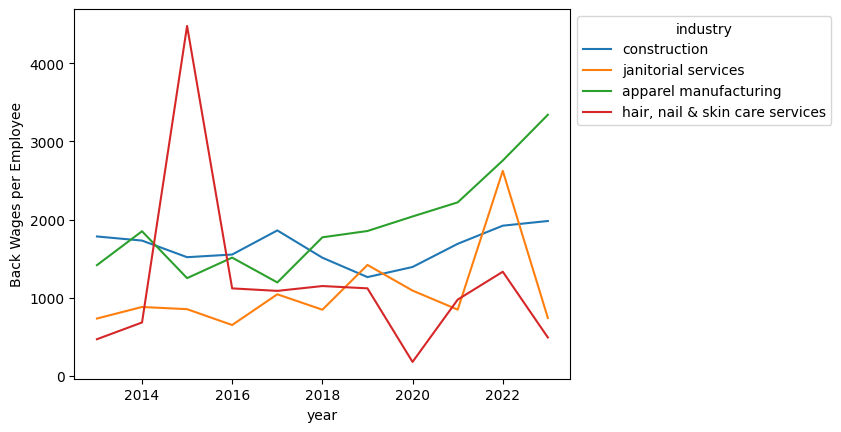

In [12]:
# Select industries changing over time

df_filtered = df_to_plot.loc[df_to_plot.industry.isin(['apparel manufacturing','janitorial services','construction','hair, nail & skin care services'])]

ax = sns.lineplot(data=df_filtered, x=df_filtered.index, y='Back Wages per Employee', hue='industry')
ax.set_xlabel('year')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Using FIPS code '12' for input 'FL'


Text(0.5, 1.0, 'Pasco sum_ann_payroll by Zip Codes, 2018')

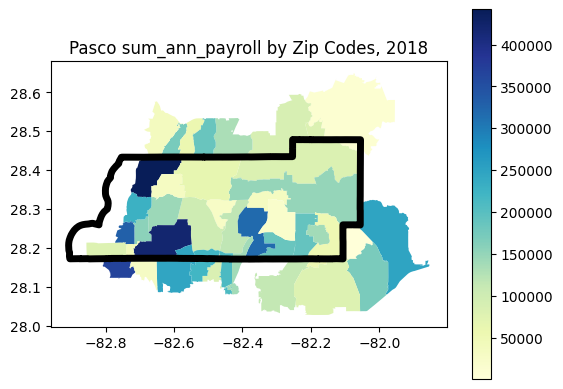

In [13]:
# Mapping US Census zip code business pattern data 
# NOT USED, only useful for estimating wage theft where businesses operate

# Pull geography information for mapping
county = 'Pasco'

gpd_county_pasco = counties(state='FL',year=2018,cache=False)
gpd_county_pasco = gpd_county_pasco.loc[gpd_county_pasco.NAME==county]

gpd_zctas_pasco  = zctas(year = 2018, cache = True, subset_by=gpd_county_pasco)

# Pulling data from api.census.gov ... Zipcode Business Patterns

var_strlist   = 'NAME,GEO_ID,NAICS2017_LABEL,EMPSZES_LABEL,PAYANN,ESTAB,EMP'
zip_code      = ','.join(str(x) for x in gpd_zctas_pasco.GEOID10.unique())
naics_strlist = '00'#,72,62,23,71,44,45'


url = f"https://api.census.gov/data/2018/zbp?get={var_strlist}&for=zip%20code:{zip_code}&NAICS2017={naics_strlist}&key={api_key}"

var_names  = {'NAME':f'zip_name',
              'NAICS2017_LABEL':f'naics_ind_name',
              'EMPSZES':'employee_size_class',
              'PAYANN':f'sum_ann_payroll',
              'ESTAB':f'count_establishments',
              'EMP':f'count_employees',
              'NAICS2017':'naics_ind_code',
              'zip code':'zipcode'}

df_zip_naics     = pd.read_json(url)
df_zip_naics     = df_zip_naics.rename(columns=df_zip_naics.iloc[0]).drop(df_zip_naics.index[0])
df_zip_naics     = df_zip_naics.rename(columns=var_names)
df_zip_naics[['sum_ann_payroll','count_establishments','count_employees']] = df_zip_naics[['sum_ann_payroll','count_establishments','count_employees']].astype(int)

df_zip_naics = pd.concat([pd.DataFrame(),df_zip_naics])

# Plotting the map

col = 'sum_ann_payroll'

plotdf = gpd_zctas_pasco.merge(df_zip_naics.loc[(df_zip_naics.count_employees.astype(int)>0)&(df_zip_naics.sum_ann_payroll<1000000),[col,'zipcode']],left_on='GEOID10',right_on='zipcode')

fig, ax = plt.subplots()
plotdf[[col,'geometry']].plot(column=col,ax = ax, cmap='YlGnBu',legend=True)
gpd_county_pasco.plot(ax = ax,edgecolor='black', facecolor='none', linewidth=5)
plt.title(f'{county} {col} by Zip Codes, 2018')

In [14]:
# focus on where to victim's live; postpone where victim's are employed for future research
# lower wage & NAICS; undocumented immigrant; race/eth; foreign born; female; language; younger age 16-25yrs
# build index by Tract for composite score of all "risk factors"
# based on # employed by NAICS & conditions within tract, apply NAICS backwages per employee estimate
#    "low wage"=Yes & ("foreign born"=Yes or Lang=NotEng or Citizen=No) & female=Yes & age<30yrs

# https://api.census.gov/data/2022/acs/acs5/subject/variables.html
#   Are there many employed in the industry in tract? S0501_C01_066E?	Estimate!!Total!!Civilian employed population 16 years and over!!INDUSTRY!!Agriculture, forestry, fishing and hunting, and mining
#   Are there many foreign born employed in the industry in tract? S0501_C03_066E	Estimate!!Foreign born!!Civilian employed population 16 years and over!!INDUSTRY!!Agriculture, forestry, fishing and hunting, and mining
#   Are there low wages earned in the tract? S0501_C01_107E	Estimate!!Total!!POVERTY STATUS IN THE PAST 12 MONTHS!!POVERTY RATES FOR FAMILIES FOR WHOM POVERTY STATUS IS DETERMINED!!All families
#   ACS 5yr detailed tables B23013_001E	Estimate!!Median age--!!Total:	Median Age by Sex for Workers 16 to 64 Years

#   Total Employees by NAICS - https://www.bls.gov/emp/industry-employment/industry.xlsx
#   Median Age of workers by NAICS - https://www.bls.gov/cps/cpsaat18b.xlsx
#   Median Weekly Earnings by NAICS - https://www.bls.gov/cps/cpsaat39.xlsx
#   Back wages per employee by NAICS - data above (if 5% of employees in NAICS in tract are experiencing wage theft, it would total $ in back wages for the tract)

#   Next up would be language, citizenship, female-male pay gap

# 
# flag tracts for likely victim of wagetheft residence risk ...
#   Risk out of 10 = if(
#      top 5 NAICS for employees receiving back wages employs +50%=2,  --should be adjusted in future for % of employees reporting backwages of total employees
#      % foreign born employed in NAICS total +10%=2,
#      poverty rate in tract +5%=2,
#      % female employed in NAICS total +50%=2,
#      median employed age in tract <30=2)
#
# then calc annual wage theft by tract for top 5 high risk NAICS ...
#   total employees * 
#   pct experiencing wage theft(68%)<low,med,high> *  ----- prevalence could be improved; DOL vs survey an underreporting estimate?
#   (median weekly earnings * 52 weeks * 0.15<low,med,high>)  ----- when back wages are owed, surveys show 15% of total wages lost